# Laboratory Final Project

- *Introduction to Statistical Computing*
- Author: Elena Conderana & Sergio Cuenca
- Date: XX/03/2025

---

## 1. Research questions

- **Which demographic groups are most affected by cost barriers to healthcare?**
- Hypothesis Research Question

---

## 2. Data
In this section, sampling techniques shall be used on the data to obtain a sample of the
population from which we can draw conclusions on the whole dataset/US population. Here are
some ideas for questions that may be answered (you can add more):
- Describe the sampling method, which technique you have used and why.
- May the results of your EDA be generalized to the whole population from the sample you
have chosen?
- Discuss potential sources of bias based on the dataset description, how can these biases
affect your conclusions?

In [1]:
import scipy.stats as stats
import pandas as pd

In [2]:
df = pd.read_csv('data/brfss2013.csv', sep=",", encoding='cp1252', on_bad_lines='skip', low_memory=False)

### 2.1. CI Data Analysis

In [3]:
df_ci = pd.DataFrame()
df_ci['medical_cost_barrier'] = df['medcost']
df_ci['health_insurance'] = df['hlthpln1']
df_ci['personal_doctor'] = df['persdoc2']
df_ci['sex'] = df['sex']
df_ci['age_group'] = df['X_ageg5yr']
df_ci['state'] = df['X_state']
df_ci['income_level'] = df['income2']
df_ci['education_level'] = df['educa']
df_ci['employment_status'] = df['employ1']
df_ci['general_health'] = df['genhlth']
df_ci['physically_unwell_days'] = df['physhlth']
df_ci['mentally_unwell_days'] = df['menthlth']
df_ci['activity_limited_days'] = df['poorhlth']
df_ci['final_weight'] = df['X_llcpwt']

na_counts = df_ci.isna().sum()
print("Missing values per column:\n", na_counts)

Missing values per column:
 medical_cost_barrier        1221
health_insurance            1904
personal_doctor             1801
sex                            7
age_group                   4730
state                          0
income_level               71426
education_level             2274
employment_status           3386
general_health              1985
physically_unwell_days     10957
mentally_unwell_days        8627
activity_limited_days     243153
final_weight                   7
dtype: int64


Drop  rows where key variables are missing (especially medical_cost_barrier, final_weight, and stratification variables like income_level, sex)

- Cost barriers are linked to income and sex: Without stratification, the sample might under- or over-represent key groups
- Stratification ensures proportional representation: Low-income and high-income groups appear in the same proportions as the population
- Leads to more accurate and generalizable CIs: We want the resulting sample to mimic the actual population structure

In [4]:
from sklearn.model_selection import train_test_split

# Drop rows with missing key values
key_vars = ['medical_cost_barrier', 'income_level', 'sex', 'final_weight']
df_clean = df_ci.dropna(subset=key_vars)

# Stratified sampling (10%) by income and sex
df_ci_sampled, _ = train_test_split(
    df_clean,
    test_size=0.9,
    stratify=df_clean[['income_level', 'sex']],
    random_state=42
)

print("Sample shape:", df_ci_sampled.shape)

Sample shape: (41953, 14)


We defined a cleaned working population (df_clean) by removing rows with missing values in essential variables required for stratified sampling and inference. From this cleaned dataset, we drew a 10% stratified random sample (df_ci_sampled) based on income and sex to ensure representativeness for confidence interval estimation and exploratory data analysis. Missing or invalid entries in key variables (e.g., medical cost barrier, sex, final weight) were excluded. This stratified sample allows us to estimate the proportion of U.S. adults who reported cost as a barrier to medical care with greater precision and confidence.

Although some variables have missing values (notably income and activity-limited days), the final sample retains sufficient size and structure to support inference. Potential biases due to missing data are addressed in the following section.

In [5]:
def category_distribution(df, column):
    return df[column].value_counts(normalize=True).sort_index()

# Compare proportions
print("Full dataset - Income distribution:\n", category_distribution(df_clean, 'income_level'))
print("Sample - Income distribution:\n", category_distribution(df_ci_sampled, 'income_level'))

print("\nFull dataset - Sex distribution:\n", category_distribution(df_clean, 'sex'))
print("Sample - Sex distribution:\n", category_distribution(df_ci_sampled, 'sex'))

Full dataset - Income distribution:
 income_level
$75,000 or more      0.276073
Less than $10,000    0.060358
Less than $15,000    0.063585
Less than $20,000    0.082836
Less than $25,000    0.099211
Less than $35,000    0.116232
Less than $50,000    0.146419
Less than $75,000    0.155286
Name: proportion, dtype: float64
Sample - Income distribution:
 income_level
$75,000 or more      0.276071
Less than $10,000    0.060353
Less than $15,000    0.063595
Less than $20,000    0.082831
Less than $25,000    0.099230
Less than $35,000    0.116225
Less than $50,000    0.146426
Less than $75,000    0.155269
Name: proportion, dtype: float64

Full dataset - Sex distribution:
 sex
Female    0.576145
Male      0.423855
Name: proportion, dtype: float64
Sample - Sex distribution:
 sex
Female    0.576121
Male      0.423879
Name: proportion, dtype: float64


We validated the representativeness of our sample by comparing the distributions of the stratification variables — income level and sex — between the sample and the full cleaned dataset.
The distributions matched almost perfectly, with absolute differences in proportions of less than 0.001 for all categories. This confirms that our stratified sampling approach successfully preserved the population structure, ensuring that the results of our EDA and confidence interval estimation can be generalized to the broader U.S. adult population surveyed by BRFSS in 2013.

### 2.2. Hypothesis Data Analysis

In [ ]:
df_hypothesis = pd.DataFrame()
df_hypothesis['heavyDrinking'] = df['X_rfdrhv4']
df_hypothesis['actLimitation'] = df['qlactlm2']
df_hypothesis['vet'] = df['veteran3'] 
df_hypothesis['healthCov'] = df['hlthpln1']
df_hypothesis['sex'] = df['sex']
df_hypothesis['avgDrinksDay'] = df['avedrnk2']
df_hypothesis['hopeless30'] = df['mishopls']
df_hypothesis['depressed30'] = df['misdeprd']
df_hypothesis['worthless30'] = df['miswtles']
df_hypothesis['employment'] = df['employ1']
df_hypothesis['kidneyDisease'] = df['chckidny']
df_hypothesis['maritalStatus'] = df['marital']
df_hypothesis['numberChildren'] = df['children']
df_hypothesis['lifeSatisfaction'] = df['lsatisfy']
df_hypothesis['stressMoneyRent12'] = df['scntmony']
df_hypothesis['emotionalSupport'] = df['emtsuprt']

In [ ]:
na_counts = df_hypothesis.isna().sum()
print(na_counts)

heavyDrinking         23883
actLimitation         11329
vet                     746
healthCov              1904
sex                       7
avgDrinksDay         260590
hopeless30           484842
depressed30          486871
worthless30          487258
employment             3386
kidneyDisease          1721
maritalStatus          3420
numberChildren         2274
lifeSatisfaction     480104
stressMoneyRent12    429616
emotionalSupport     480154
dtype: int64


In [ ]:
# Drop rows where 'vet' is NaN for sampling purposes
df_for_sampling = df.dropna(subset=['veteran3']).copy()

# Map 'veteran3' to numerical values for 'vet_flag'
df_for_sampling['vet_flag'] = df_for_sampling['veteran3'].map({'Yes': 1, 'No': 2}).astype(int)

# Calculate the proportions of veterans and non-veterans in the complete dataset
total_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 1])
total_non_veterans = len(df_for_sampling[df_for_sampling['vet_flag'] == 2])
total_population = len(df_for_sampling)

proportion_veterans = total_veterans / total_population
proportion_non_veterans = total_non_veterans / total_population

# Define the total sample size
total_sample_size = int(0.1 * total_population)

# Calculate the sample sizes for each group based on the proportions
n_veterans = int(total_sample_size * proportion_veterans)
n_non_veterans = int(total_sample_size * proportion_non_veterans)

# Separate into strata
veterans = df_for_sampling[df_for_sampling['vet_flag'] == 1]
non_veterans = df_for_sampling[df_for_sampling['vet_flag'] == 2]

# Perform random sampling within each stratum
veteran_sample = veterans.sample(n=min(n_veterans, len(veterans)), random_state=42)
non_veteran_sample = non_veterans.sample(n=min(n_non_veterans, len(non_veterans)), random_state=42)

# Combine the samples
df_hypothesis_sampled = pd.concat([veteran_sample, non_veteran_sample])

# Now create your final df_hypothesis DataFrame with the sampled data
df_hypothesis = pd.DataFrame()
df_hypothesis['heavyDrinking'] = df_hypothesis_sampled['X_rfdrhv4']
df_hypothesis['actLimitation'] = df_hypothesis_sampled['qlactlm2']
df_hypothesis['vet'] = df_hypothesis_sampled['veteran3']
df_hypothesis['healthCov'] = df_hypothesis_sampled['hlthpln1']
df_hypothesis['sex'] = df_hypothesis_sampled['sex']
df_hypothesis['avgDrinksDay'] = df_hypothesis_sampled['avedrnk2']
df_hypothesis['hopeless30'] = df_hypothesis_sampled['mishopls']
df_hypothesis['depressed30'] = df_hypothesis_sampled['misdeprd']
df_hypothesis['worthless30'] = df_hypothesis_sampled['miswtles']
df_hypothesis['employment'] = df_hypothesis_sampled['employ1']
df_hypothesis['kidneyDisease'] = df_hypothesis_sampled['chckidny']
df_hypothesis['maritalStatus'] = df_hypothesis_sampled['marital']
df_hypothesis['numberChildren'] = df_hypothesis_sampled['children']
df_hypothesis['lifeSatisfaction'] = df_hypothesis_sampled['lsatisfy']
df_hypothesis['stressMoneyRent12'] = df_hypothesis_sampled['scntmony']
df_hypothesis['emotionalSupport'] = df_hypothesis_sampled['emtsuprt']
df_hypothesis['bingeDrinking'] = df_hypothesis_sampled['X_rfbing5']

# Convert 'vet' to a more descriptive categorical variable
df_hypothesis['vet_label'] = df_hypothesis['vet'].map({'Yes':1, 'No':0})

# Convert 'heavyDrinking' to a more descriptive categorical variable
df_hypothesis['heavyDrinking_label'] = df_hypothesis['heavyDrinking'].map({'No':0, 'Yes':1})

print(f"Sample size (veterans): {len(veteran_sample)}")
print(f"Sample size (non-veterans): {len(non_veteran_sample)}")
print(f"Total sample size: {len(df_hypothesis)}")

Sample size (veterans): 6144
Sample size (non-veterans): 42957
Total sample size: 49101


In [223]:
df_hypothesis

,heavyDrinking,actLimitation,vet,healthCov,sex,avgDrinksDay,hopeless30,depressed30,worthless30,employment,kidneyDisease,maritalStatus,numberChildren,lifeSatisfaction,stressMoneyRent12,emotionalSupport,bingeDrinking,vet_label,heavyDrinking_label
468454,No,No,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Widowed,0.0,NaN,NaN,NaN,No,1,0.0
297746,No,No,Yes,Yes,Male,NaN,NaN,NaN,NaN,Employed for wages,No,Married,0.0,NaN,NaN,NaN,No,1,0.0
94377,No,No,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Widowed,0.0,NaN,NaN,NaN,No,1,0.0
20359,No,No,Yes,Yes,Male,NaN,NaN,NaN,NaN,Retired,No,Married,0.0,NaN,Never,NaN,No,1,0.0
406247,No,Yes,Yes,Yes,Male,1.0,NaN,NaN,NaN,Retired,No,Married,0.0,NaN,NaN,NaN,No,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,No,No,No,Yes,Female,1.0,NaN,NaN,NaN,Employed for wages,No,Married,0.0,NaN,NaN,NaN,Yes,0,0.0
306706,No,No,No,Yes,Female,1.0,NaN,NaN,NaN,A homemaker,No,Married,0.0,NaN,NaN,NaN,No,0,0.0
429668,No,No,No,Yes,Female,NaN,NaN,NaN,NaN,Employed for wages,Yes,Married,3.0,NaN,NaN,NaN,No,0,0.0
67124,Yes,No,No,Yes,Female,4.0,NaN,NaN,NaN,Employed for wages,No,Divorced,0.0,NaN,NaN,NaN,Yes,0,1.0


---

## 3. EDA
In this section, perform an explorative analysis to answer the proposed questions in the previous
section. Justify the results and draw conclusions based on this analysis.

In [6]:
import seaborn as sns

# Set style and palette
sns.set_theme(style="whitegrid")

### 3.1. CI EDA
#### 3.1.1. Self-Report Bias – General Health Distribution

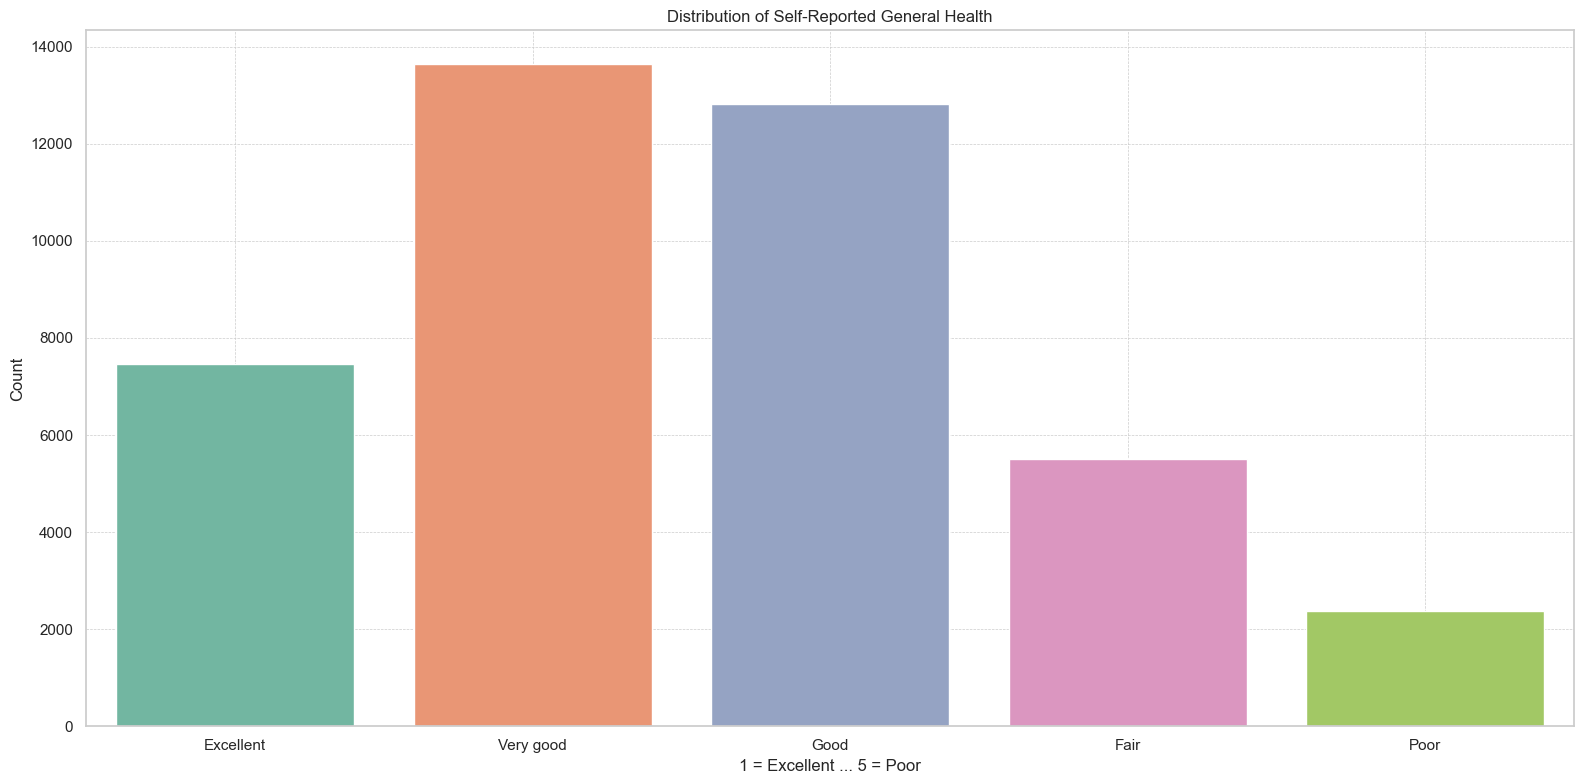

In [7]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Set up the color palette
palette = sns.color_palette('Set2', n_colors=5)

# Ensure 'general_health' is a categorical variable with the right order
df_ci_sampled['general_health'] = pd.Categorical(
    df_ci_sampled['general_health'],
    categories=['Excellent', 'Very good', 'Good', 'Fair', 'Poor'],
    ordered=True
)

fig, ax = plt.subplots(figsize=(16, 8))

# Plot on the defined axis
sns.countplot(data=df_ci_sampled, x='general_health', palette=palette, ax=ax)

# Add title and labels
ax.set_title('Distribution of Self-Reported General Health')
ax.set_xlabel('1 = Excellent ... 5 = Poor')
ax.set_ylabel('Count')
ax.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

BRFSS relies entirely on self-reported data, which introduces the risk of self-report bias. Individuals may overstate healthy behaviors, underreport unhealthy ones, or misremember their experiences. This is particularly relevant for sensitive questions like mental health, healthcare access, or income.
To examine this, we analyzed the distribution of self-reported general health. The results show a strong skew toward positive responses — with most respondents reporting “Very Good” or “Good” health, and very few selecting “Poor.” This skew suggests a social desirability bias, where individuals present themselves in a more favorable light

#### 3.1.2. Coverage Bias – Top/Bottom States by Response %

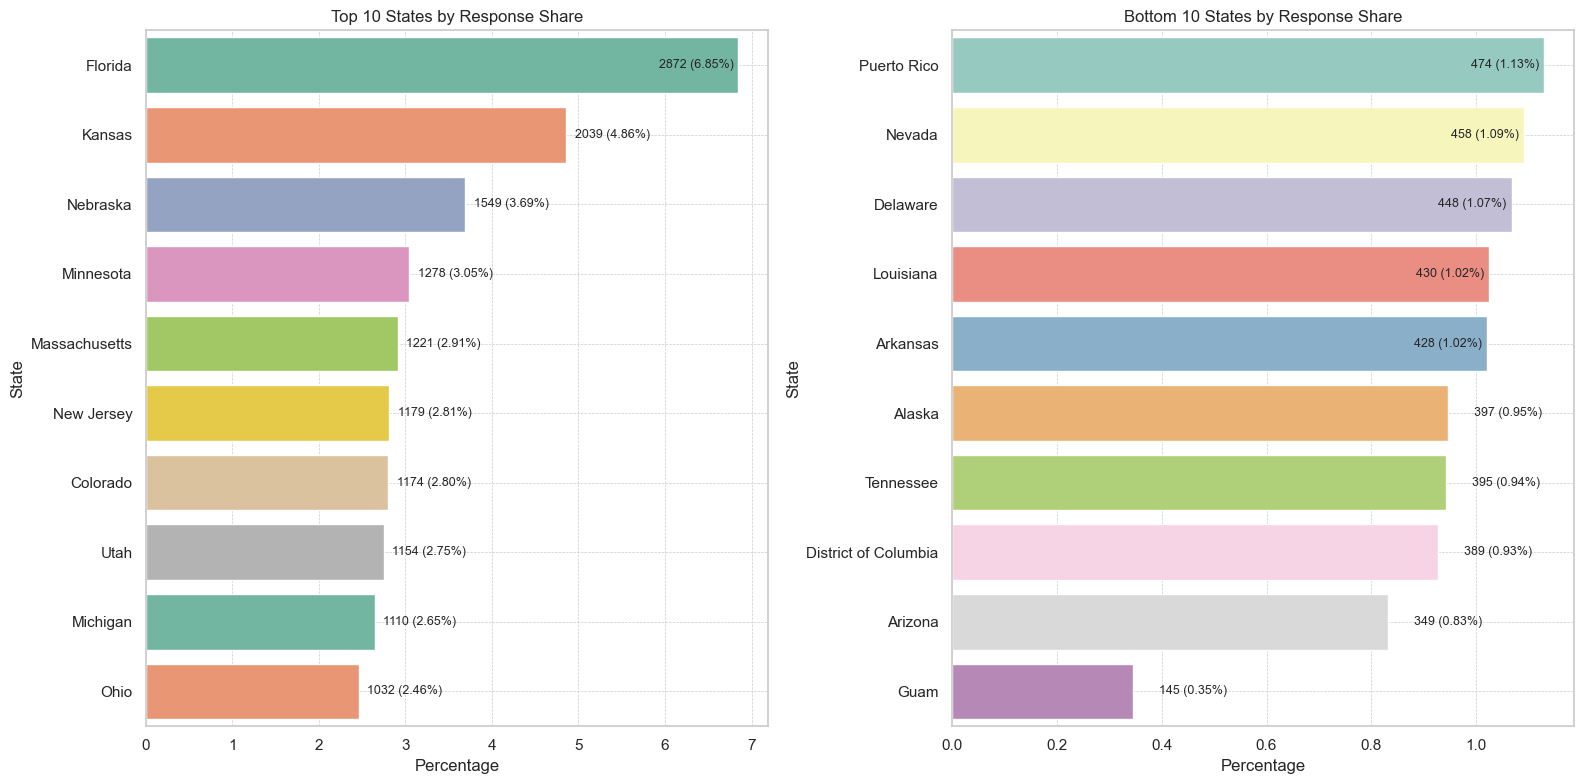

In [8]:
state_counts = df_ci_sampled['state'].value_counts(normalize=True) * 100
state_counts_abs = df_ci_sampled['state'].value_counts()

top_states = state_counts.head(10)
bottom_states = state_counts.tail(10)

palette_left = sns.color_palette("Set2", n_colors=10)
palette_right = sns.color_palette("Set3", n_colors=10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(x=top_states.values, y=top_states.index, ax=axes[0], palette=palette_left)
axes[0].set_title("Top 10 States by Response Share")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("State")
axes[0].grid(True, which="both", ls="--", linewidth=0.5)

for i, state in enumerate(top_states.index):
    percent = top_states[state]
    count = state_counts_abs[state]
    text = f"{count} ({percent:.2f}%)"
    x_offset = 0.1 if percent < 6.5 else -0.05
    ha = 'left' if percent < 6.5 else 'right'
    axes[0].text(percent + x_offset, i, text, va='center', ha=ha, fontsize=9)

sns.barplot(x=bottom_states.values, y=bottom_states.index, ax=axes[1], palette=palette_right)
axes[1].set_title("Bottom 10 States by Response Share")
axes[1].set_xlabel("Percentage")
axes[1].set_ylabel("State")
axes[1].grid(True, which="both", ls="--", linewidth=0.5)

for i, state in enumerate(bottom_states.index):
    percent = bottom_states[state]
    count = state_counts_abs[state]
    text = f"{count} ({percent:.2f}%)"
    x_offset = 0.05 if percent < 1 else -0.01
    ha = 'left' if percent < 1 else 'right'
    axes[1].text(percent + x_offset, i, text, va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.show()

The BRFSS is a telephone-based survey targeting non-institutionalized U.S. adults. As a result, the dataset may exclude certain vulnerable groups, such as people in prisons, nursing homes, or without reliable phone access.
To explore potential coverage bias, we examined the state distribution in the dataset. Some states are significantly overrepresented (e.g., Florida with 6.85%) while others are underrepresented (e.g., Alaska, Tennesse, D.C., each with less than 1%). Although these differences may reflect sampling quotas or population size, they suggest that certain regions or populations may be less represented, potentially affecting national estimates of healthcare access and cost barriers.

#### 3.1.3. Missing Data Bias - Nonresponse by Variable

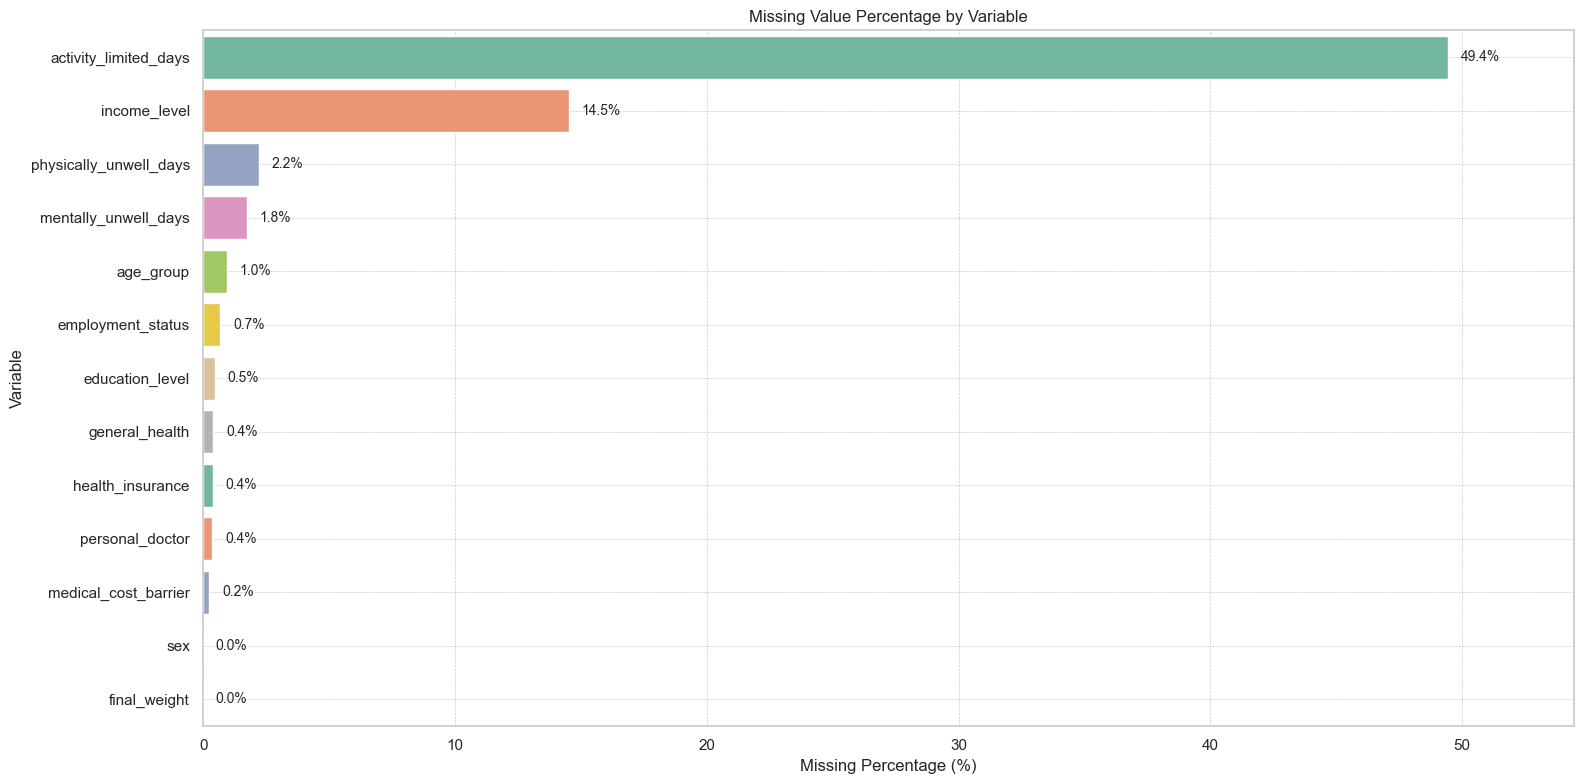

In [9]:
na_summary = df_ci.isna().mean().sort_values(ascending=False) * 100
na_summary_filtered = na_summary[na_summary > 0]

plt.figure(figsize=(16, 8))
ax = sns.barplot(x=na_summary_filtered.values, y=na_summary_filtered.index, palette="Set2")

for i, (value, label) in enumerate(zip(na_summary_filtered.values, na_summary_filtered.index)):
    ax.text(value + 0.5, i, f"{value:.1f}%", va='center', ha='left', fontsize=10)

plt.title("Missing Value Percentage by Variable")
plt.xlabel("Missing Percentage (%)")
plt.ylabel("Variable")
plt.xlim(0, max(na_summary_filtered.values) + 5)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


One notable source of potential bias in our dataset is missing data, particularly in the variable activity_limited_days, which is missing in approximately 49% of the cases. This high rate of nonresponse may be due to survey structure (e.g., optional modules or follow-up logic).

Additionally, income_level is missing in 14.5% of respondents, and this is especially relevant as income is one of the key variables related to healthcare access. To mitigate bias, we excluded missing income cases before stratified sampling and confidence interval estimation. However, we acknowledge that if the missingness is not random — for example, if lower-income individuals are less likely to report income — this could introduce systematic bias and underrepresent certain vulnerable groups.
Other variables like mental_health and employment_status had low levels of missing data and were handled using available-case analysis, dropping rows only when those variables were directly involved in a particular analysis.


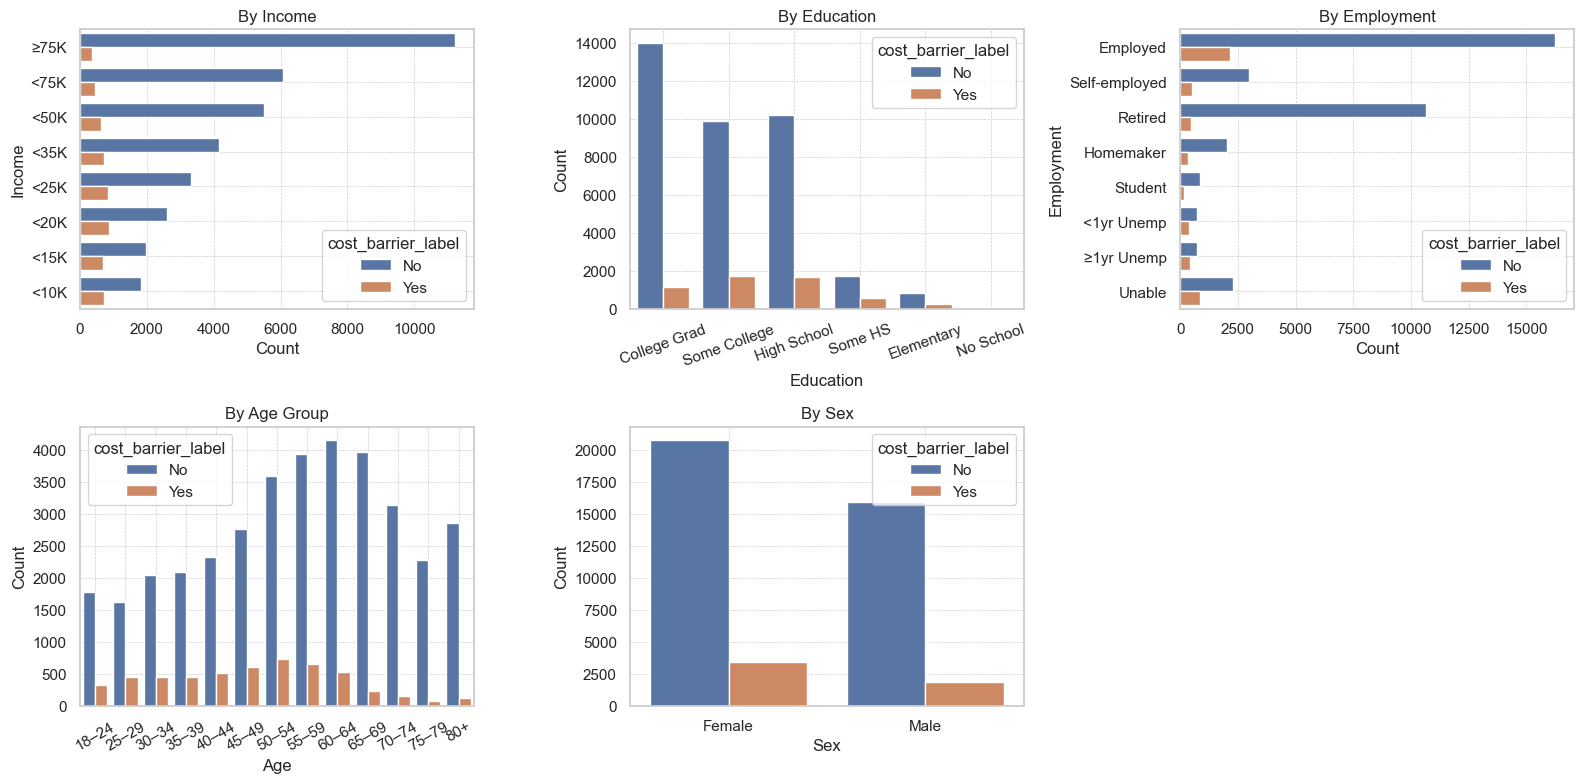

In [10]:
income_labels = {
    '$75,000 or more': '≥75K', 'Less than $75,000': '<75K', 'Less than $50,000': '<50K',
    'Less than $35,000': '<35K', 'Less than $25,000': '<25K', 'Less than $20,000': '<20K',
    'Less than $15,000': '<15K', 'Less than $10,000': '<10K'
}
education_labels = {
    'College 4 years or more (College graduate)': 'College Grad',
    'College 1 year to 3 years (Some college or technical school)': 'Some College',
    'Grade 12 or GED (High school graduate)': 'High School',
    'Grades 9 though 11 (Some high school)': 'Some HS',
    'Grades 1 through 8 (Elementary)': 'Elementary',
    'Never attended school or only kindergarten': 'No School'
}
employment_labels = {
    'Employed for wages': 'Employed', 'Self-employed': 'Self-employed', 'Retired': 'Retired',
    'A homemaker': 'Homemaker', 'A student': 'Student',
    'Out of work for less than 1 year': '<1yr Unemp',
    'Out of work for 1 year or more': '≥1yr Unemp',
    'Unable to work': 'Unable'
}
age_labels = {
    'Age 18 to 24': '18–24', 'Age 25 to 29': '25–29', 'Age 30 to 34': '30–34',
    'Age 35 to 39': '35–39', 'Age 40 to 44': '40–44', 'Age 45 to 49': '45–49',
    'Age 50 to 54': '50–54', 'Age 55 to 59': '55–59', 'Age 60 to 64': '60–64',
    'Age 65 to 69': '65–69', 'Age 70 to 74': '70–74', 'Age 75 to 79': '75–79',
    'Age 80 or older': '80+'
}

# Labels
cost_labels = {"Yes": "Yes", "No": "No"}
sex_labels = {"Male": "Male", "Female": "Female"}
df_ci_sampled['cost_barrier_label'] = df_ci_sampled['medical_cost_barrier'].map(cost_labels)
df_ci_sampled['sex_label'] = df_ci_sampled['sex'].map(sex_labels)

# Mappings
df_plot = df_ci_sampled.copy()
df_plot['income_label'] = df_plot['income_level'].map(income_labels)
df_plot['education_label'] = df_plot['education_level'].map(education_labels)
df_plot['employment_label'] = df_plot['employment_status'].map(employment_labels)
df_plot['age_label'] = df_plot['age_group'].map(age_labels)

# Define categorical ordering
income_order = ['≥75K', '<75K', '<50K', '<35K', '<25K', '<20K', '<15K', '<10K']
edu_order = list(education_labels.values())
emp_order = list(employment_labels.values())
age_order = list(age_labels.values())

df_plot['income_label'] = pd.Categorical(df_plot['income_label'], categories=income_order, ordered=True)
df_plot['education_label'] = pd.Categorical(df_plot['education_label'], categories=edu_order, ordered=True)
df_plot['employment_label'] = pd.Categorical(df_plot['employment_label'], categories=emp_order, ordered=True)
df_plot['age_label'] = pd.Categorical(df_plot['age_label'], categories=age_order, ordered=True)

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Income – Horizontal countplot
sns.countplot(data=df_plot, y='income_label', hue='cost_barrier_label', order=income_order, ax=axes[0, 0])
axes[0, 0].set_title("By Income")
axes[0, 0].set_xlabel("Count")
axes[0, 0].set_ylabel("Income")
axes[0, 0].grid(True, which="both", ls="--", linewidth=0.5)

# 2. Education – Vertical countplot
sns.countplot(data=df_plot, x='education_label', hue='cost_barrier_label', order=edu_order, ax=axes[0, 1])
axes[0, 1].set_title("By Education")
axes[0, 1].set_xlabel("Education")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis='x', rotation=20)
axes[0, 1].grid(True, which="both", ls="--", linewidth=0.5)

# 3. Employment – Horizontal countplot
sns.countplot(data=df_plot, y='employment_label', hue='cost_barrier_label', order=emp_order, ax=axes[0, 2])
axes[0, 2].set_title("By Employment")
axes[0, 2].set_xlabel("Count")
axes[0, 2].set_ylabel("Employment")
axes[0, 2].grid(True, which="both", ls="--", linewidth=0.5)

# 4. Age – Vertical countplot
sns.countplot(data=df_plot, x='age_label', hue='cost_barrier_label', order=age_order, ax=axes[1, 0])
axes[1, 0].set_title("By Age Group")
axes[1, 0].set_xlabel("Age")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', rotation=30)
axes[1, 0].grid(True, which="both", ls="--", linewidth=0.5)

# 5. Sex – Vertical countplot
sns.countplot(data=df_plot, x='sex_label', hue='cost_barrier_label', ax=axes[1, 1])
axes[1, 1].set_title("By Sex")
axes[1, 1].set_xlabel("Sex")
axes[1, 1].set_ylabel("Count")
axes[1, 1].grid(True, which="both", ls="--", linewidth=0.5)

# 6. Empty
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


To explore which populations are most affected by cost barriers to healthcare, we analyzed the distribution of responses to the question *Was there a time in the past 12 months when you needed to see a doctor but could not because of cost?* across various demographic dimensions.

The following five subplots illustrate the distribution of cost barriers by income level, education, employment status, age group, and sex.

Key Findings:
- Income: There is a strong inverse relationship between income and cost barriers. Individuals earning less than $15,000 per year are significantly more likely to report being unable to afford medical care. In contrast, cost is rarely a barrier for those earning $75,000 or more.
- Education: Respondents with lower educational attainment (e.g., no school, elementary, or some high school) show higher vulnerability to cost barriers, while college graduates are the least affected.
- Employment Status: Unemployed individuals—especially those who have been out of work for more than a year or are unable to work—are the most impacted by cost-related healthcare access issues. Employed and retired individuals report far fewer such barriers.
- Age: Younger adults (particularly those between 18–34) are more likely to experience cost barriers, likely due to less stable employment and insurance coverage. This effect diminishes significantly with age, especially past 65, possibly due to Medicare eligibility.
- Sex: Females show a slightly higher frequency of reporting cost as a barrier compared to males. While not a dramatic gap, this aligns with broader trends in healthcare access disparities between genders.

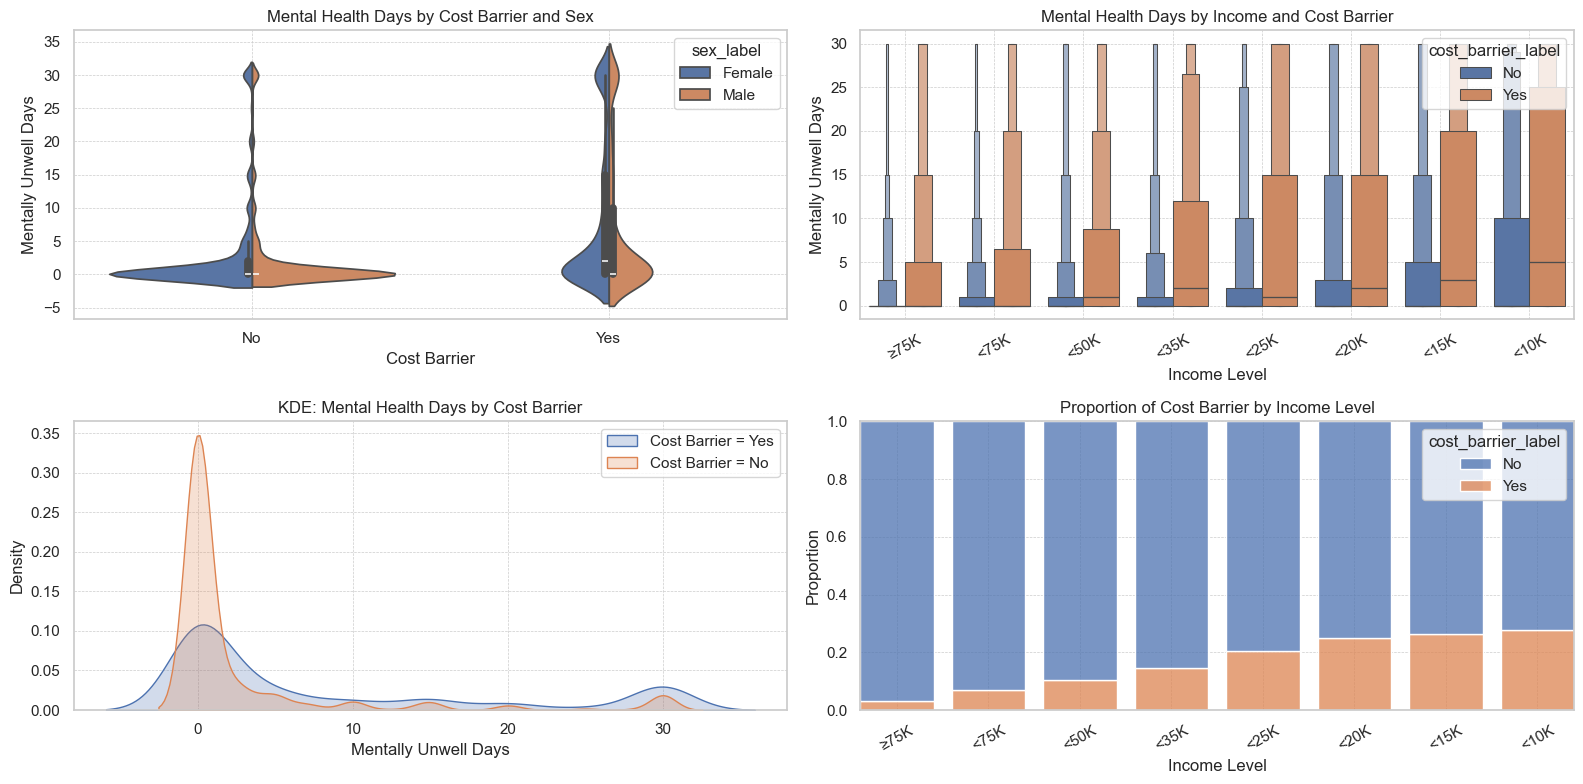

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Violinplot: Mental Health by Cost Barrier & Sex
sns.violinplot(
    data=df_plot,
    x='cost_barrier_label',
    y='mentally_unwell_days',
    hue='sex_label',
    split=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Mental Health Days by Cost Barrier and Sex")
axes[0, 0].set_xlabel("Cost Barrier")
axes[0, 0].set_ylabel("Mentally Unwell Days")
axes[0, 0].grid(True, ls="--", linewidth=0.5)

# Boxenplot: Mentally Unwell Days by Income & Cost Barrier
sns.boxenplot(
    data=df_plot,
    x='income_label',
    y='mentally_unwell_days',
    hue='cost_barrier_label',
    order=income_order,
    ax=axes[0, 1]
)
axes[0, 1].set_title("Mental Health Days by Income and Cost Barrier")
axes[0, 1].set_xlabel("Income Level")
axes[0, 1].set_ylabel("Mentally Unwell Days")
axes[0, 1].tick_params(axis='x', rotation=30)
axes[0, 1].grid(True, ls="--", linewidth=0.5)

# Mental Health Distribution by Cost Barrier
sns.kdeplot(
    data=df_plot[df_plot['cost_barrier_label'] == 'Yes'],
    x='mentally_unwell_days',
    label='Cost Barrier = Yes',
    fill=True,
    ax=axes[1, 0]
)
sns.kdeplot(
    data=df_plot[df_plot['cost_barrier_label'] == 'No'],
    x='mentally_unwell_days',
    label='Cost Barrier = No',
    fill=True,
    ax=axes[1, 0]
)
axes[1, 0].set_title("KDE: Mental Health Days by Cost Barrier")
axes[1, 0].set_xlabel("Mentally Unwell Days")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, ls="--", linewidth=0.5)

# Cost Barrier by Income Level
sns.histplot(
    data=df_plot,
    x='income_label',
    hue='cost_barrier_label',
    multiple='fill',
    shrink=0.8,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Proportion of Cost Barrier by Income Level")
axes[1, 1].set_xlabel("Income Level")
axes[1, 1].set_ylabel("Proportion")
axes[1, 1].tick_params(axis='x', rotation=30)
axes[1, 1].grid(True, ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()


To investigate whether cost barriers are also associated with mental health outcomes, we explored self-reported mentally unwell days over the past 30 days in relation to cost access issues. The second set of subplots focuses on this relationship.

Key Findings:
- Violin Plot (Sex × Cost Barrier): Individuals who reported not being able to afford medical care tend to have a broader and higher distribution of mentally unwell days. Among them, females report more severe mental health symptoms than males.
- Boxen Plot (Income × Cost Barrier): This visualization shows that low-income individuals who face cost barriers report a significantly higher number of mentally unwell days. As income increases, the gap between "Yes" and "No" responses narrows, suggesting financial security may buffer mental health consequences.
- KDE Plot: The kernel density estimation reveals a clear difference in the distribution of mental distress. The peak for individuals without cost barriers is around 0–1 mentally unwell days, while for those with cost barriers, the distribution is flatter and more right-skewed, indicating a larger proportion experiencing frequent mental distress.
- Proportion by Income Level: Visualizing cost barriers as proportions rather than counts further confirms that low-income populations are significantly more likely to delay or forgo care due to cost. In the "<10K" group, roughly 1 in 3 individuals reported a cost barrier, compared to less than 5% in the highest income group.

### 3.2. Hypothesis Testing EDA

employ1: Employment Status
qlactlm2: Activity Limitation Due To Health Problems
marital: Marital Status


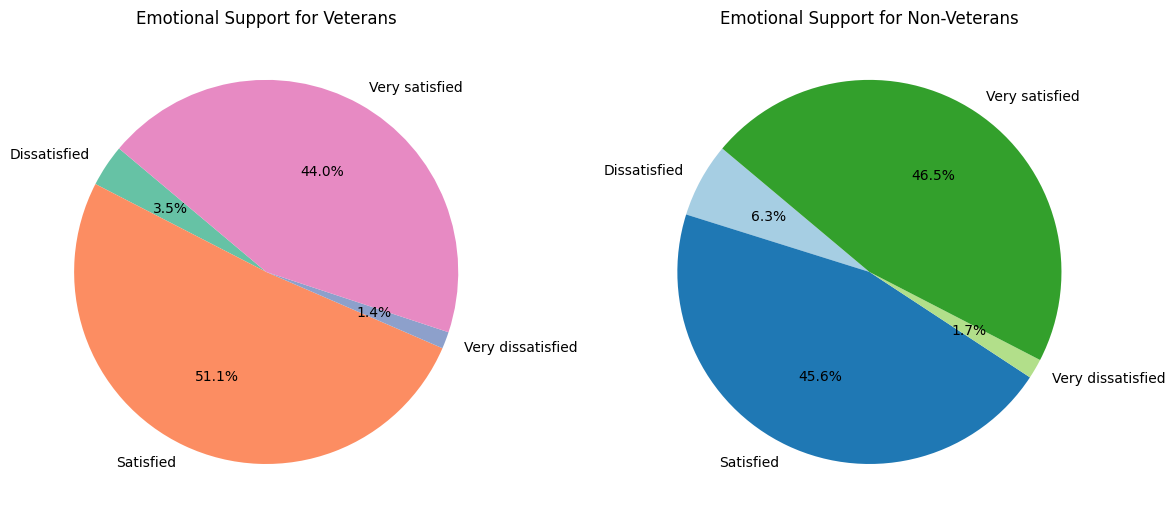

In [ ]:
# Aggregate data for emotional support by veteran status
emotional_support_counts = df_hypothesis.groupby(['vet', 'lifeSatisfaction']).size().reset_index(name='Count')

# Separate data for veterans and non-veterans
veteran_support = emotional_support_counts[emotional_support_counts['vet'] == 'Yes']
non_veteran_support = emotional_support_counts[emotional_support_counts['vet'] == 'No']

# Plot pie chart for veterans
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(veteran_support['Count'], labels=veteran_support['lifeSatisfaction'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Set2.colors)
plt.title('Emotional Support for Veterans')

# Plot pie chart for non-veterans
plt.subplot(1, 2, 2)
plt.pie(non_veteran_support['Count'], labels=non_veteran_support['lifeSatisfaction'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Emotional Support for Non-Veterans')

plt.tight_layout()
plt.show()

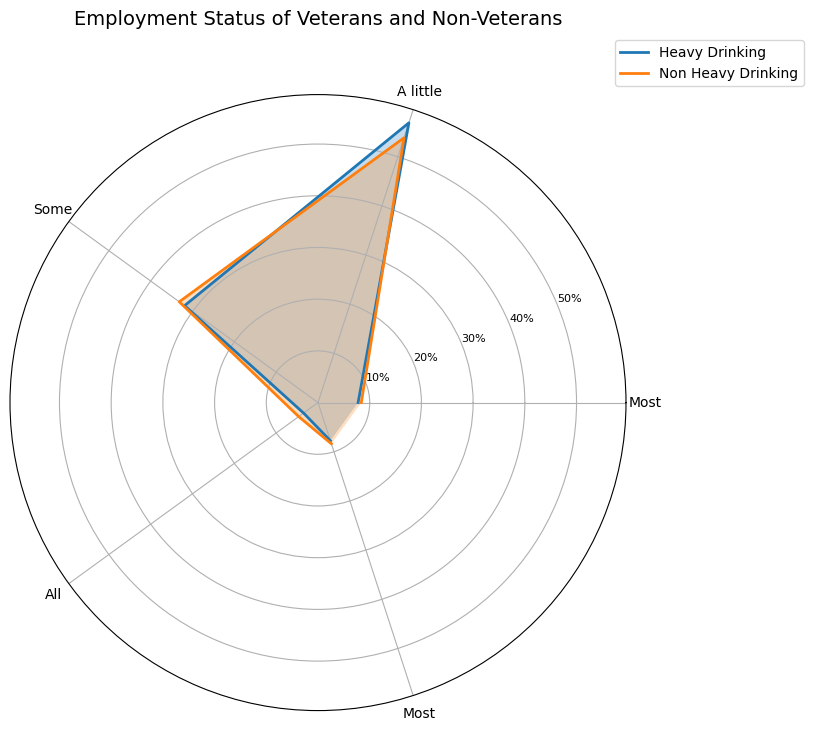

: 

In [ ]:
from math import pi

# Prepare data for radar chart
employment_status = df_hypothesis['hopeless30'].unique()
employment_status = [status for status in employment_status if pd.notna(status)]  # Remove NaN values

# Calculate proportions for each employment status
veteran_employment = df_hypothesis[df_hypothesis['bingeDrinking'] == 'Yes']['hopeless30'].value_counts(normalize=True)
non_veteran_employment = df_hypothesis[df_hypothesis['bingeDrinking'] == 'No']['hopeless30'].value_counts(normalize=True)

# Ensure all employment statuses are included
veteran_values = [veteran_employment.get(status, 0) for status in employment_status]
non_veteran_values = [non_veteran_employment.get(status, 0) for status in employment_status]

# Add the first value to close the radar chart
veteran_values += veteran_values[:1]
non_veteran_values += non_veteran_values[:1]
employment_status += [employment_status[0]]

# Create radar chart
angles = [n / float(len(employment_status)) * 2 * pi for n in range(len(employment_status))]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot data
ax.plot(angles[:-1], veteran_values, linewidth=2, linestyle='solid', label='Heavy Drinking')
ax.fill(angles[:-1], veteran_values, alpha=0.25)

ax.plot(angles[:-1], non_veteran_values, linewidth=2, linestyle='solid', label='Non Heavy Drinking')
ax.fill(angles[:-1], non_veteran_values, alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(employment_status, fontsize=10)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%'], fontsize=8)
ax.set_title('Employment Status of Veterans and Non-Veterans', size=14, y=1.1)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

In [ ]:
# Calculate proportions of activity limitations by veteran status
act_limitation_proportions = df_hypothesis.groupby('vet')['actLimitation'].value_counts(normalize=True).unstack()

# Display the proportions
print(act_limitation_proportions)

actLimitation        No       Yes
vet                              
No             0.764115  0.235885
Yes            0.696238  0.303762


C:\Users\Elena\AppData\Local\Temp\ipykernel_9048\2951302514.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_hypothesis.dropna(subset=['avgDrinksDay', 'vet']), x='vet', y='avgDrinksDay', palette=['#90EE90', '#ADD8E6'], ax=axs[2], legend=True) #changed palette


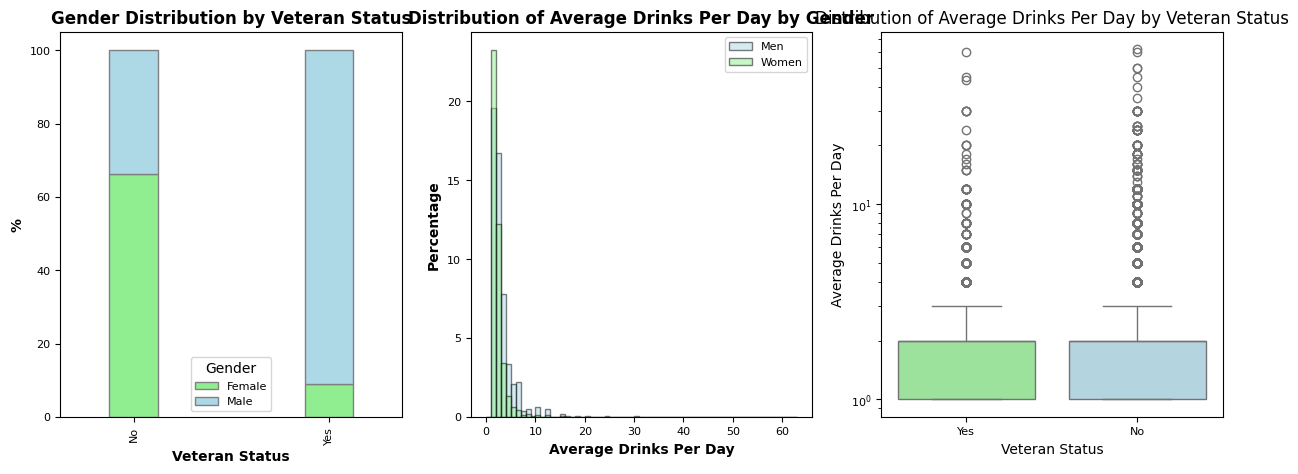

In [ ]:
# Define bar width
barWidth = 0.25
fig, axs = plt.subplots(1, 3, figsize=(16, 8))  # Adjusted for side-by-side, and reduced height

# First Chart: Gender Distribution by Veteran Status
# Group data by 'vet' and 'sex' and calculate percentages
grouped_data = df_hypothesis.groupby(['vet', 'sex']).size().unstack()
grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plot bars for each gender
grouped_data_percentage.plot(kind='bar', stacked=True, width=barWidth, ax=axs[0], color=['#90EE90', '#ADD8E6'], edgecolor='grey')

# Set labels and title
axs[0].set_xlabel('Veteran Status', fontweight='bold', fontsize=10)
axs[0].set_ylabel('%', fontweight='bold', fontsize=10)
axs[0].set_title('Gender Distribution by Veteran Status', fontweight='bold', fontsize=12)
axs[0].tick_params(axis='both', labelsize=8)

# Add legend
axs[0].legend(title='Gender', labels=['Female', 'Male'], fontsize=8)


# Second Chart: Distribution of Average Drinks Per Day by Gender
# Filter data by gender
male_data = df_hypothesis[df_hypothesis['sex'] == 'Male']['avgDrinksDay']
female_data = df_hypothesis[df_hypothesis['sex'] == 'Female']['avgDrinksDay']

# Determine the maximum value for consistent bin edges
max_val = df_hypothesis['avgDrinksDay'].max()
bins = range(int(max_val) + 2)  # Ensure bins go beyond the max value, +2 to include the top value.

# Plot histograms with logarithmic scale and consistent bins
n_male, bins_male, patches_male = axs[1].hist(male_data, bins=bins, alpha=0.5, label='Men', color='#ADD8E6', edgecolor='black', log=True)
n_female, bins_female, patches_female = axs[1].hist(female_data, bins=bins, alpha=0.5, label='Women', color='#90EE90', edgecolor='black', log=True)

# Calculate percentages
total_male = len(male_data)
total_female = len(female_data)
percentage_male = [x / total_male * 100 for x in n_male]
percentage_female = [x / total_female * 100 for x in n_female]

# Clear the current axes and plot the percentages
axs[1].cla()
axs[1].bar(bins_male[:-1], percentage_male, width=1, align='edge', alpha=0.5, label='Men', color='#ADD8E6', edgecolor='black')
axs[1].bar(bins_female[:-1], percentage_female, width=1, align='edge', alpha=0.5, label='Women', color='#90EE90', edgecolor='black')


# Add labels, title, and legend
axs[1].set_xlabel('Average Drinks Per Day', fontweight='bold', fontsize=10)
axs[1].set_ylabel('Percentage', fontweight='bold', fontsize=10) # Changed Y label to percentage
axs[1].set_title('Distribution of Average Drinks Per Day by Gender', fontweight='bold', fontsize=12)
axs[1].legend(fontsize=8)
axs[1].tick_params(axis='both', labelsize=8)

# Third Chart: Average Drinks Per Day by Heavy Drinking Status
# Use the same colors as the bar chart for the boxplot
sns.boxplot(data=df_hypothesis.dropna(subset=['avgDrinksDay', 'vet']), x='vet', y='avgDrinksDay', palette=['#90EE90', '#ADD8E6'], ax=axs[2], legend=True) #changed palette
axs[2].set_title('Distribution of Average Drinks Per Day by Veteran Status', fontsize=12)
axs[2].set_xlabel('Veteran Status', fontsize=10)
axs[2].set_ylabel('Average Drinks Per Day', fontsize=10)
axs[2].set_yscale('log')
axs[2].tick_params(axis='both', labelsize=8)


Display proportion of population that cannot drink (pregnant, under age,...)

---

## 4. Inference statistics
In this section, perform a statistical analysis on the data to respond to the research questions
proposed in section 1. You have to answer at least one question via confidence interval and at
least one question via hypothesis testing. Alternatively, you can answer one of the questions
using a Bayesian model. 

### 4.1. CI Statistics

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 95% confidence level
z = norm.ppf(0.975)  # ~1.96

def compute_ci(df, group_col, response_col='cost_barrier_label', positive_label='Yes'):
    results = []
    for group, subset in df.groupby(group_col):
        n = len(subset)
        x = (subset[response_col] == positive_label).sum()
        p_hat = x / n
        se = np.sqrt((p_hat * (1 - p_hat)) / n)
        ci_low = p_hat - z * se
        ci_high = p_hat + z * se
        results.append({
            group_col: group,
            'n': n,
            'count_yes': x,
            'proportion': p_hat,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        })
    return pd.DataFrame(results).sort_values(by='proportion', ascending=False)

age_order = [
    '18–24', '25–29', '30–34', '35–39', '40–44',
    '45–49', '50–54', '55–59', '60–64', '65–69',
    '70–74', '75–79', '80+'
]

df_plot['cost_barrier_label'] = df_plot['cost_barrier_label'].astype('category')
df_plot['income_label'] = df_plot['income_label'].cat.remove_unused_categories()
df_plot['education_label'] = df_plot['education_label'].cat.remove_unused_categories()
df_plot['employment_label'] = df_plot['employment_label'].cat.remove_unused_categories()
df_plot['sex_label'] = df_plot['sex_label'].astype('category')
df_plot['age_label'] = pd.Categorical(df_plot['age_label'], categories=age_order, ordered=True)

ci_income = compute_ci(df_plot, 'income_label')
ci_education = compute_ci(df_plot, 'education_label')
ci_employment = compute_ci(df_plot, 'employment_label')
ci_sex = compute_ci(df_plot, 'sex_label')
ci_age = compute_ci(df_plot, 'age_label')
ci_age['age_label'] = pd.Categorical(ci_age['age_label'], categories=age_order, ordered=True)
ci_age = ci_age.sort_values('age_label')

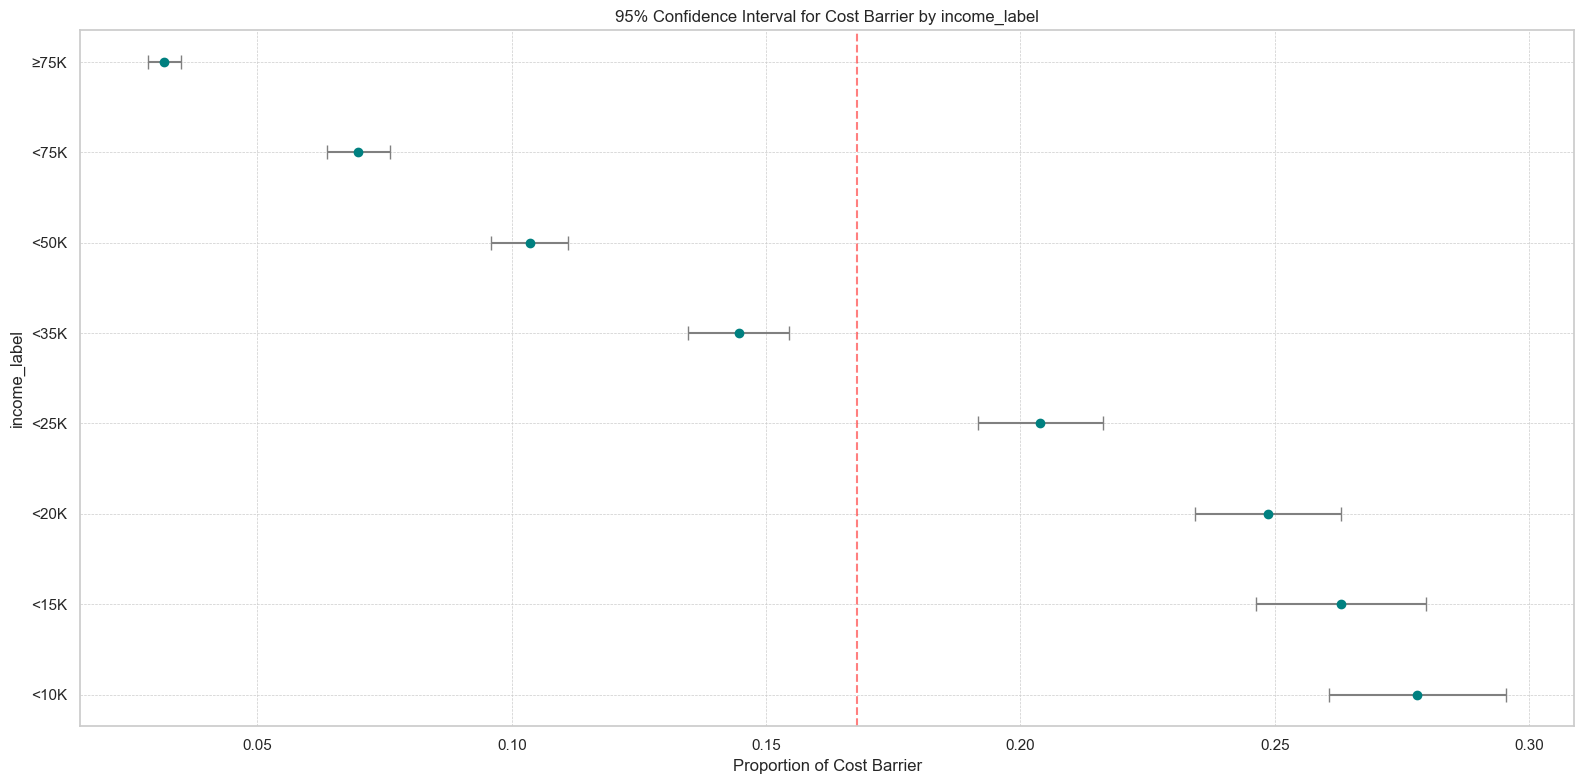

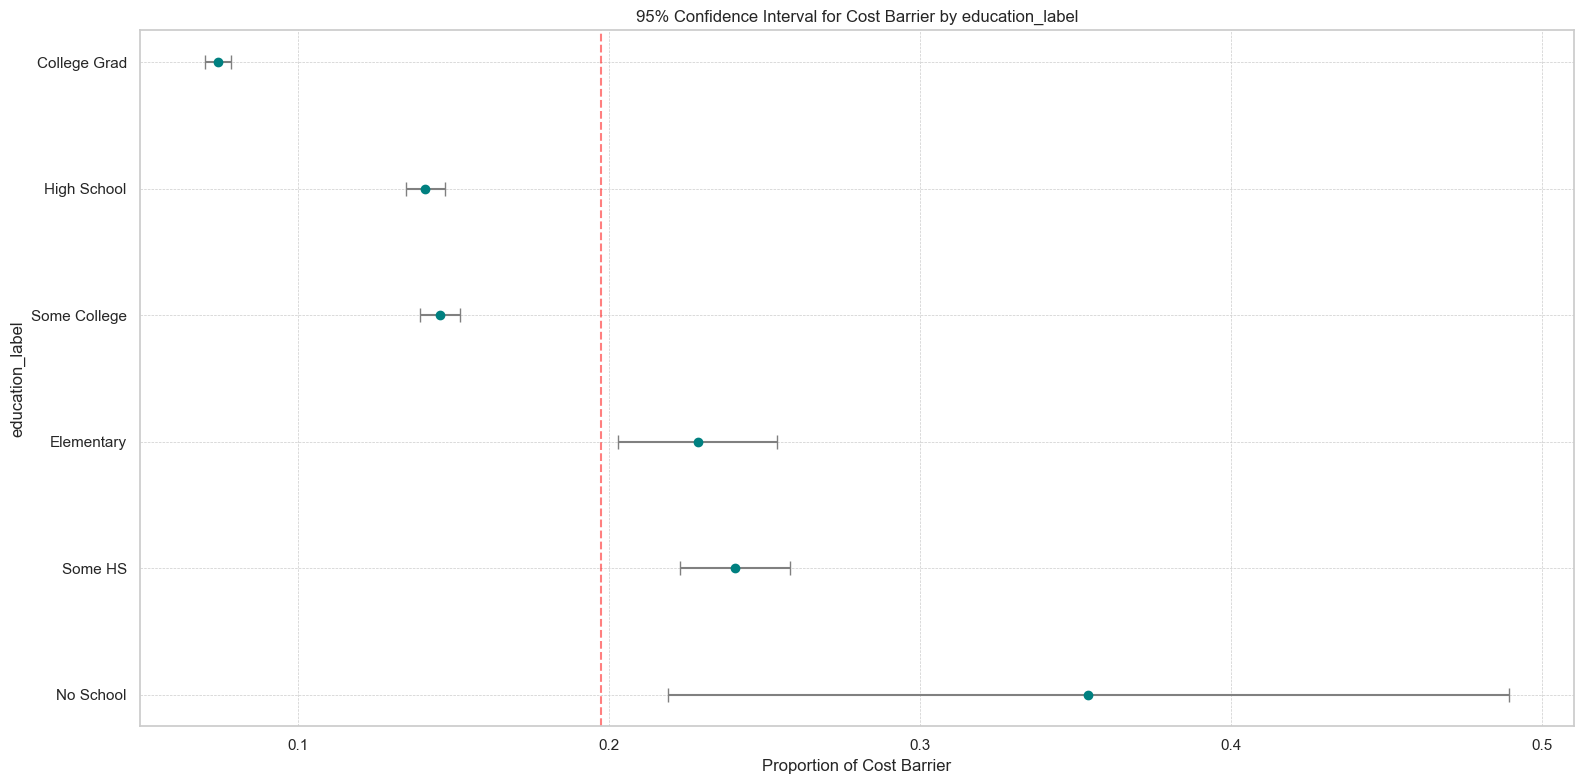

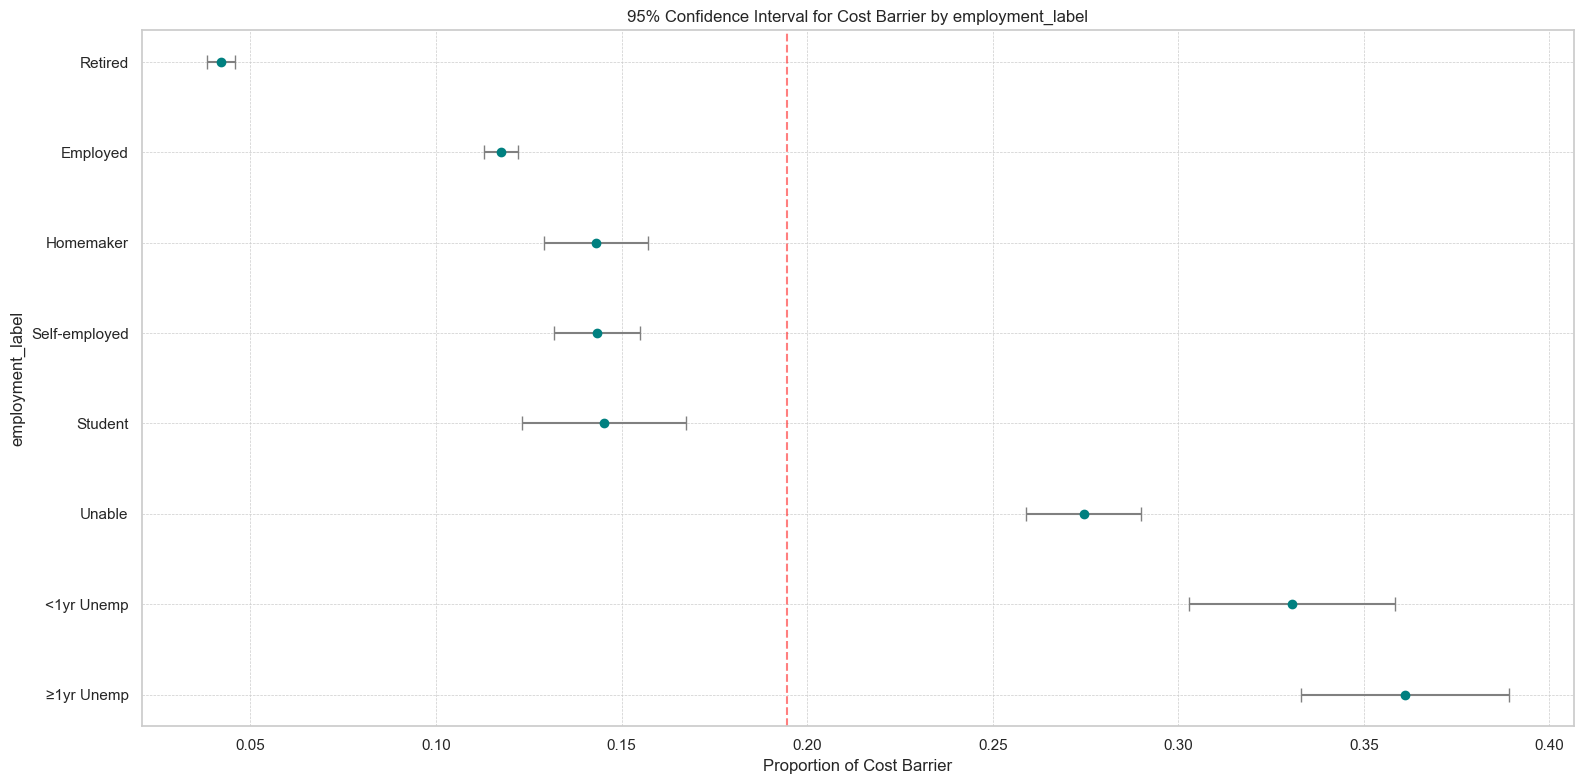

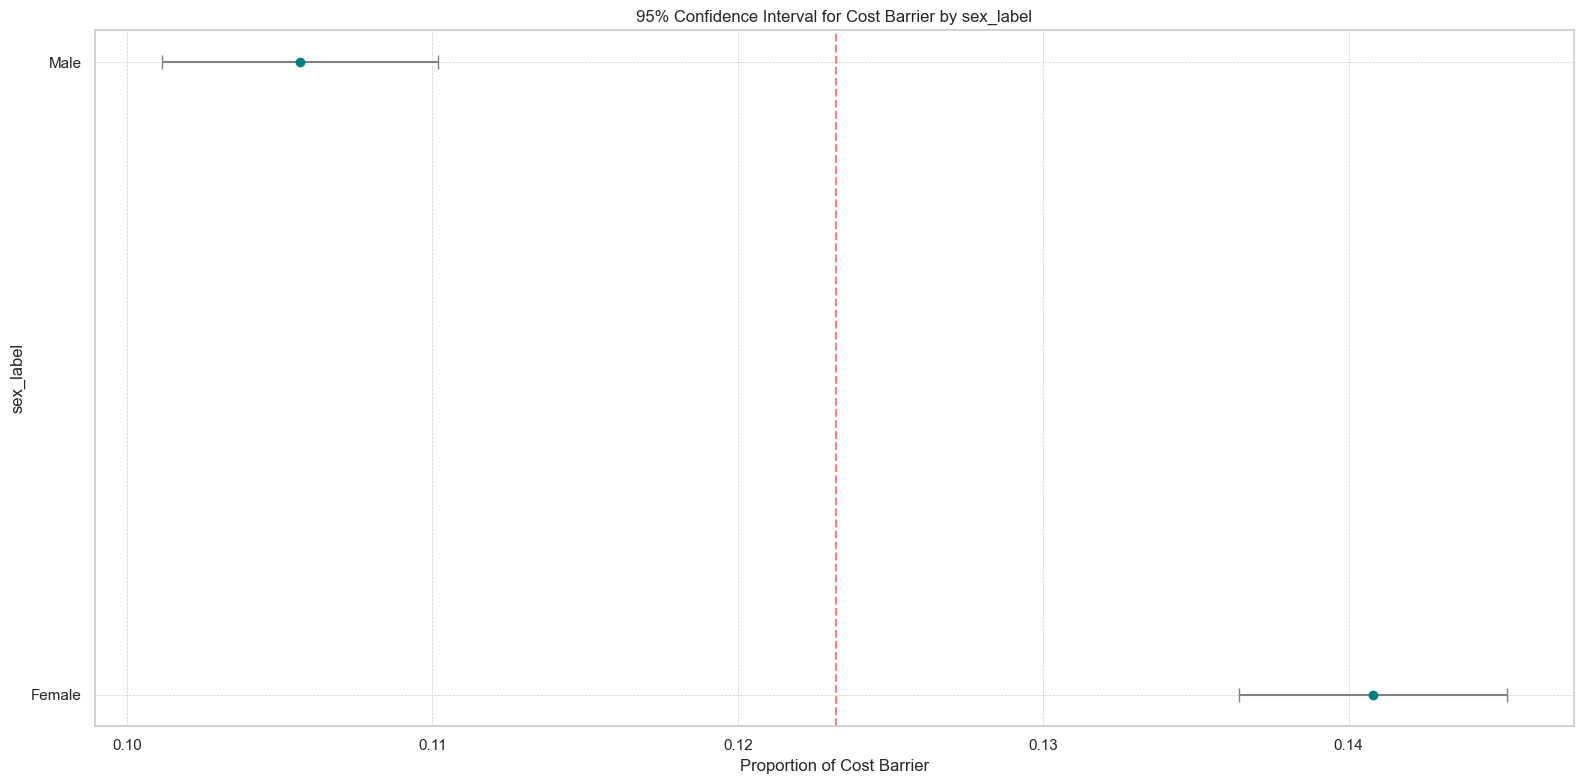

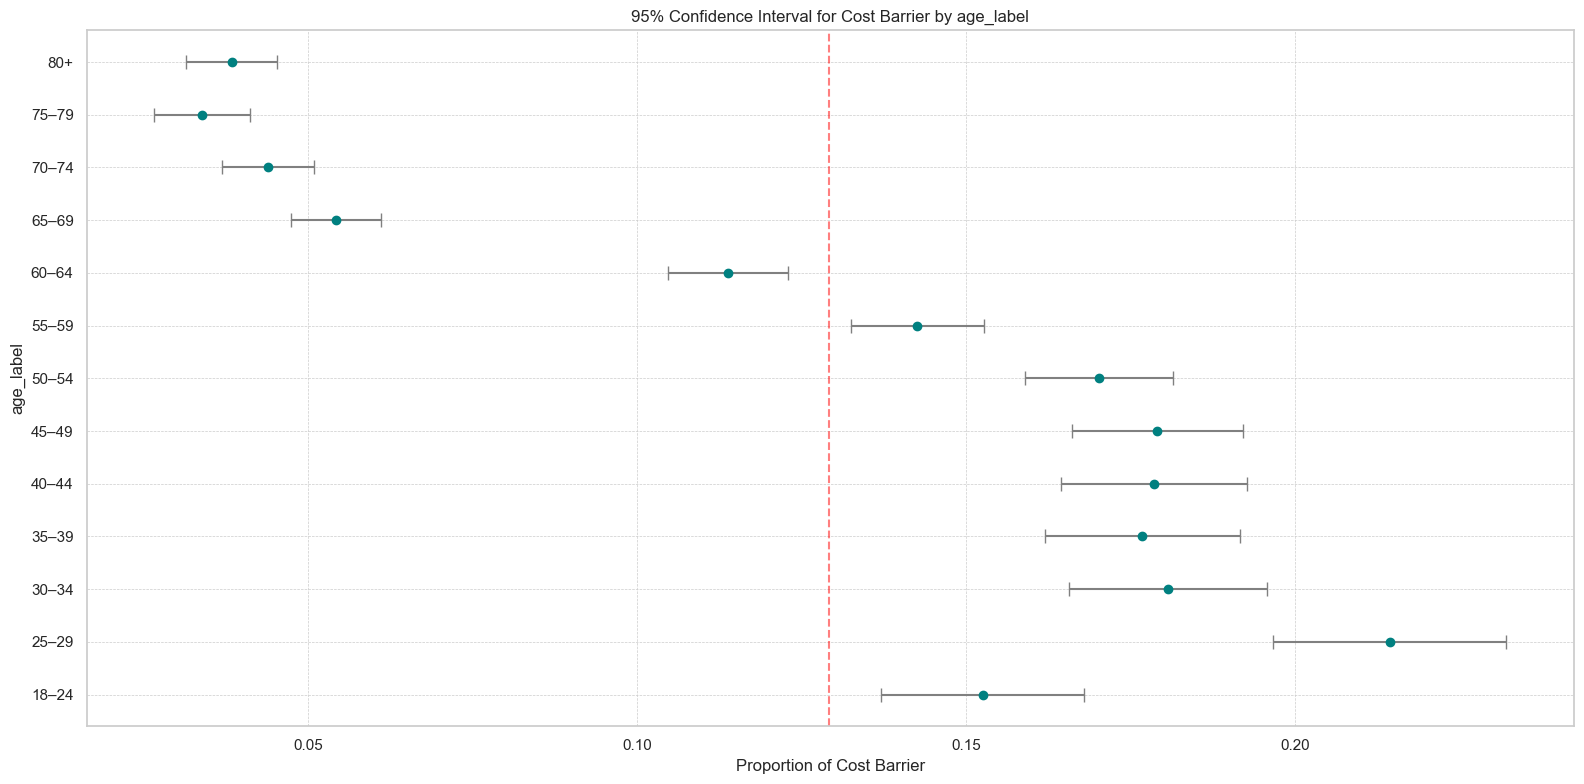

In [13]:
def plot_ci(df_ci, group_col, title):
    plt.figure(figsize=(16, 8))
    plt.errorbar(
        x=df_ci['proportion'],
        y=df_ci[group_col],
        xerr=[df_ci['proportion'] - df_ci['ci_lower'], df_ci['ci_upper'] - df_ci['proportion']],
        fmt='o',
        capsize=5,
        color='teal',
        ecolor='gray'
    )
    plt.axvline(x=df_ci['proportion'].mean(), color='red', linestyle='--', alpha=0.5)
    plt.xlabel("Proportion of Cost Barrier")
    plt.ylabel(group_col)
    plt.title(f"95% Confidence Interval for Cost Barrier by {group_col}")
    plt.grid(True, ls='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_ci(ci_income, 'income_label', "Income")
plot_ci(ci_education, 'education_label', "Education")
plot_ci(ci_employment, 'employment_label', "Employment")
plot_ci(ci_sex, 'sex_label', "Sex")
plot_ci(ci_age, 'age_label', "Age Group")

To statistically compare how cost barriers affect different demographic groups, we computed 95% confidence intervals for the proportion of individuals in each group who reported being unable to see a doctor due to cost.

- Overlap: Inconclusive (Not automatically “no difference”). It suggests there's not enough evidence (from this visual alone) to claim the proportions differ significantly.
- No Overlap → Statistically Significant Difference (very likely). If the CIs do not overlap, it’s usually a strong indicator of a statistically significant difference between groups.

These intervals allow us to quantify uncertainty around each estimate and identify statistically meaningful differences between groups. For example:
- Individuals with lower income (<15K) and those with no formal education are significantly more likely to experience cost barriers. Their confidence intervals are both higher and non-overlapping with wealthier or more educated groups.
- Among employment statuses, long-term unemployed and those unable to work show the highest proportions, with confidence intervals well above the population average.
- Younger adults, particularly in the 25–34 age range, report higher cost barriers compared to older adults. Notably, individuals aged 65+ (likely Medicare-covered) report the lowest.
- The difference by sex is small but statistically significant: females are slightly more likely to report cost barriers, and their CI lies entirely above that of males.
Overall, confidence intervals reinforce that cost-related access to healthcare is not randomly distributed, but disproportionately affects socially and economically vulnerable groups.

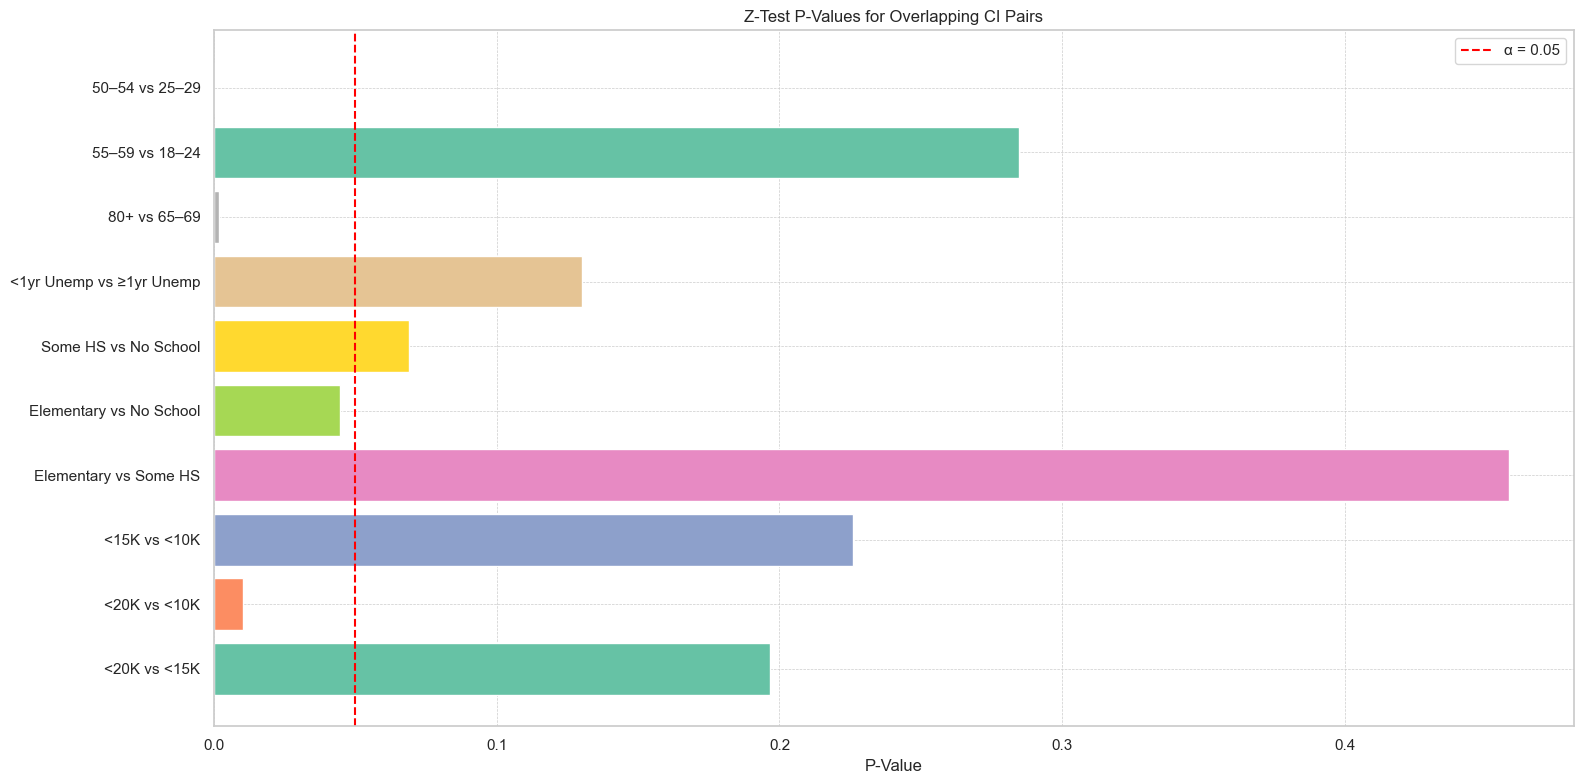

In [15]:
colors = sns.color_palette("Set2")

ci_income['category'] = 'Income'
ci_education['category'] = 'Education'
ci_employment['category'] = 'Employment'
ci_sex['category'] = 'Sex'
ci_age['category'] = 'Age'

ci_income = ci_income.rename(columns={'income_label': 'group'})
ci_education = ci_education.rename(columns={'education_label': 'group'})
ci_employment = ci_employment.rename(columns={'employment_label': 'group'})
ci_sex = ci_sex.rename(columns={'sex_label': 'group'})
ci_age = ci_age.rename(columns={'age_label': 'group'})

ci_all_real = pd.concat([ci_income, ci_education, ci_employment, ci_sex, ci_age], axis=0)

#  Overlapping pairs
overlapping_pairs = [
    ('<20K', '<15K'), ('<20K', '<10K'), ('<15K', '<10K'),
    ('Elementary', 'Some HS'), ('Elementary', 'No School'), ('Some HS', 'No School'),
    ('<1yr Unemp', '≥1yr Unemp'),
    ('80+', '65–69'), ('55–59', '18–24'), ('50–54', '25–29')
]

# Perform Z-tests
def z_test_proportions(p1, n1, p2, n2):
    p_pool = (p1 * n1 + p2 * n2) / (n1 + n2)
    se_pool = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z_score = (p1 - p2) / se_pool
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return z_score, p_value

results = []
for g1, g2 in overlapping_pairs:
    if g1 in ci_all_real['group'].values and g2 in ci_all_real['group'].values:
        row1 = ci_all_real[ci_all_real['group'] == g1].iloc[0]
        row2 = ci_all_real[ci_all_real['group'] == g2].iloc[0]
        z, p = z_test_proportions(row1['proportion'], row1['n'], row2['proportion'], row2['n'])
        results.append({
            'Group 1': g1,
            'Group 2': g2,
            'Category': row1['category'],
            'Prop 1': row1['proportion'],
            'Prop 2': row2['proportion'],
            'Z-Score': z,
            'P-Value': p
        })

results_df_final = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(16, 8))
plt.barh(
    y=[f"{row['Group 1']} vs {row['Group 2']}" for _, row in results_df_final.iterrows()],
    width=results_df_final['P-Value'],
    color=colors
)
plt.axvline(0.05, color='red', linestyle='--', label='α = 0.05')
plt.xlabel("P-Value")
plt.title("Z-Test P-Values for Overlapping CI Pairs")
plt.legend()
plt.grid(True, ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()

To go beyond visual overlaps in confidence intervals (CIs), we applied two-proportion z-tests to selected group pairs. These tests determine whether differences in proportions are statistically significant, even when confidence intervals overlap.

The horizontal bar chart displays p-values from z-tests between group pairs. The red dashed line marks p = 0.05, our standard threshold for statistical significance:

- Bars to the left of the red line (p < 0.05):
    - The difference is statistically significant — unlikely due to chance.
    - We reject the null hypothesis of equal proportions.

- Bars to the right (p ≥ 0.05):
    - We cannot rule out that the difference is due to random variation.
    - The difference is not statistically significant.

Key Findings:
- <20K vs <10K (Income): Even among very low-income groups, the barrier is significantly higher for those earning less than $10K. Smaller income still drives meaningful increases in healthcare inaccessibility.
- Elementary vs No School (Education): People with no formal schooling face significantly more cost-related barriers than those with just elementary education. Suggests the protective effect of even minimal education.
- 80+ vs 65–69 (Age): Although both are elderly, individuals aged 80+ report fewer cost barriers than those 65–69. Could reflect differences in healthcare usage, support systems, or financial stability post-retirement.
- 50–54 vs 25–29 (Age): Despite overlapping CIs, the difference is statistically significant. Younger adults (25–29) are much more affected by cost barriers than middle-aged adults (50–54). This reinforces the idea that younger populations without stable jobs or insurance are at higher risk.

Summary:

This analysis clarifies where overlapping confidence intervals still reflect true differences, and where they do not. Statistically significant contrasts — especially among income, education, and age groups — help pinpoint high-priority demographics for policy interventions aimed at reducing cost-related healthcare access barriers.

### 4.2. Hypothesis Testing Statistics

## Inference for two proportions

In [225]:
# Sample data
sample_size_vet = len(df_hypothesis[df_hypothesis['vet'] == 'Yes'])
sample_size_non_vet = len(df_hypothesis[df_hypothesis['vet'] == 'No'])
sample_count_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'Yes') & (df_hypothesis['bingeDrinking'] == 'Yes')])
sample_count_non_vet_heavy = len(df_hypothesis[(df_hypothesis['vet'] == 'No') & (df_hypothesis['bingeDrinking'] == 'Yes')])

# Sample proportions
sample_p_vet = sample_count_vet_heavy/sample_size_vet
sample_p_non_vet = sample_count_non_vet_heavy/sample_size_non_vet

# Pooled proportion
p_pooled = (sample_count_vet_heavy + sample_count_non_vet_heavy)/(sample_size_vet + sample_size_non_vet)

# Standard error
sample_std = np.sqrt(p_pooled * (1 - p_pooled) * (1 / sample_size_vet + 1 / sample_size_non_vet))

# Z-score
z_score = (sample_p_vet - sample_p_non_vet) / sample_std

# Test type
test_type = 'two-sided' # 'one-sided'

# Calculate p-value
if test_type == 'two-sided':
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # Two-tailed test
elif test_type == 'one-sided':
    p_value = (1 - stats.norm.cdf(abs(z_score))) # One-tailed test

# Significance level
alpha = 0.05

# Results
print("Z-score:", z_score)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. The proportions are significantly different.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the proportions.")

Z-score: -2.417914433240362
P-value: 0.01560974701843132
Reject the null hypothesis. The proportions are significantly different.
